안녕하세요! 데이크루 6기 ~팀입니다.

'병원 개/폐업 분류 예측 경진대회'를 기반으로 프로젝트를 진행하고 있습니다.

본 포스팅은 데이콘 서포터즈 "데이크루" 6기 활동으로 작성되었음을 알립니다.

Colab 환경으로 개발을 진행하였습니다.

---

## STEP3. 모델링

저희 팀은 모델링에 앙상블 기법을 사용하였습니다.

**앙상블(Ensemble) 기법**이란?
- 여러 개의 분류기를 생성하고 그 예측을 결합함으로써 보다 정확한 예측을 도출하는 기법

기존의 하나의 모델만을 사용하는 방법 대신, 약한 모델을 여러 개 사용하는 방법을 통해 성능을 향상시킬 수 있습니다.

앙상블 기법은 크게 보팅(Voting), 배깅(Bagging), 부스팅(Boosting) 세 개의 유형으로 나눌 수 있습니다.

보팅(Voting)은 서로 다른 알고리즘을 가진 분류기 중 투표(Vote)를 통해 최종 예측 결과를 결정하는 방식입니다.
- 하드 보팅(Hard Voting) : 각각의 분류기의 결과값 중 가장 많이 나온 값을 선정
- 소프트 보팅(Soft Voting) : 분류기의 확률의 평균을 구하고, 가장 값이 높은 것을 선정

배깅(Bagging)은 Bootstrap aggregating의 줄임말로 여러 개의 bootstrap 자료를 모델링한 후 결합하여 최종 예측 모형을 산출하는 방식입니다. 이때, 자료는 기존의 Data에서 복원 추출 방식을 통해 생성합니다.

부스팅(Boosting)은 오분류된 개체들에 집중해 새로운 분류 규칙을 만드는 단계를 반복하는 방식입니다. 보팅은 여러 개의 분류기 중 선택하는 방식이라면 부스팅은 결합하는 방식이라고 볼 수 있습니다.

#### 필요한 Library 불러오기

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# Required Libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

저희는 앙상블 기법에 Random Forest, Gradient Boosting, Xgboost 세 개의 모델을 사용했습니다.

*모든 모델링에는 똑같은 결과 재현을 보장하기 위해 np.random.seed(100)을 사용했습니다*

#### Random Forest; RF

**Random Forest**는 오버피팅을 방지하기 위해, 최적의 기준 변수를 선택하는 breiman(2002)이 제안한 머신러닝 기법으로, 여러 개의 Decision Tree를 활용한 배깅 방식의 알고리즘입니다.

Ramdom Forest는 문제 유형에 따라 회귀 모델과 분류 모델로 나뉘는데 병원 개/폐업 예측 문제의 경우에는 0과 1로 나누는 분류 문제이므로 RandomForestClassifier를 사용하였습니다.

In [17]:
# - Random Forest Model
np.random.seed(100)
RF_prod = RandomForestClassifier(n_estimators=10)
RF_prod_model = RF_prod.fit(train_prod_X, train_prod_Y)
RF_prod_prediction = RF_prod.predict_proba(test_prod_X)[:,1]

#### Gradient Boosting Machine; GBM

GBM은 부스팅 기법을 사용한 알고리즘으로 잔차(Residual)를 이용하여 이전 모형의 약점을 보완하는 새로운 모형을 순차적으로 적합하며 새로 얻은 모형을 사용하는 방식입니다.

In [18]:
# - GBM Model
np.random.seed(100)
GBM_prod = GradientBoostingClassifier(n_estimators=10)
GBM_prod_model = GBM_prod.fit(train_prod_X, train_prod_Y)
GBM_prod_prediction = GBM_prod.predict_proba(test_prod_X)[:,1]

#### XGBoost; XGB

XGBoost는 Extreme Gradient Boosting의 약자로, 부스팅 기법을 사용한 알고리즘입니다. Gradient Tree Boosting에 과적합 방지를 위한 파라미터가 추가되었고, Regression, Classification 모두 지원하며 성능과 자원 효율이 좋아 많이 사용되는 알고리즘입니다.

[XGBoost의 파라미터]
- 일반 파라미터

> booster[default=gbtree] : 부스터 구조 결정  
> n_jobs : XGBsoot를 실행하는 데 사용되는
병렬 스레드 수  
> verbosity[default=1] : 유효한 값은 0 (무음), 1 (경고), 2 (정보), 3 (디버그)

- 부스터 파라미터


> learning_rate[default=0.3]  
> n_estimators[default=100] : 생성한 weak learner의 수  
> max_depth[default=6] : 트리의 최대 깊이

- 학습 과정 파라미터


> objective[default:reg=squarederror]  
> eval_metric : 모델의 평가 함수를 조정하는 함수





In [19]:
# - XGBOOST Model
def eval_error(preds, dtrain):
    """Custom evaluation function for XGBoost."""
    labels = dtrain.get_label()
    preds = (preds > 0.5).astype('float')
    return "f1_score", f1_score(labels, preds)

dtrain_prod = xgb.DMatrix(train_prod_X, label=train_prod_Y)
dtest_prod = xgb.DMatrix(test_prod_X)

param = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'eta': 0.3,
    'colsample_bytree': 1,
    'subsample': 1,
    'silent': 0
}

np.random.seed(100)
xgb_model = xgb.train(param,
                      dtrain_prod,
                      num_boost_round=2,
                      feval=eval_error)

XGB_prediction = xgb_model.predict(dtest_prod)

[06:32:14] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



/usr/local/lib/python3.10/dist-packages/xgboost/training.py:39: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


**변수중요도**

XGBoost 모델의 경우의 변수 중요도는 다음과 같습니다.  


**변수 중요도**란?
- 해당 변수가 상대적으로 얼마만큼 종속변수에 영향을 주는가에 대한 척도

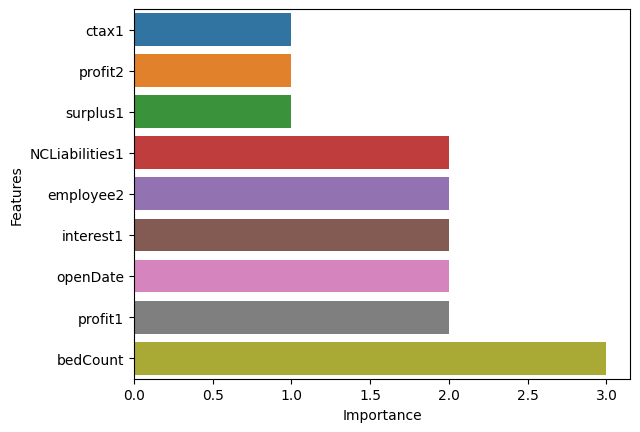

In [20]:
# - Visualize Feature Importance
xgb_Imp = pd.DataFrame({
    'Features': list(xgb_model.get_score().keys()),
    'Importance': list(xgb_model.get_score().values())
}).sort_values(['Importance'])
sns.barplot(x=xgb_Imp.Importance, y=xgb_Imp.Features)
plt.show()

---

### STEP4. Prediction

저희팀은 앙상블기법 중 Soft Voting을 사용했습니다.  
이를 위해, 보팅 모델 별 예측 확률 값을 구한 뒤 평균을 내고, 이 값이 threshold(임계값) 보다 높으면 1 아니면 0으로 결과값을 선정합니다.  
이때, 0부터 1까지 threshold 바꿔가면서 f1 score 측정해서 f1score가 가장 높게 나오는 threshold을 선정하였습니다.

**F1 score**
- 분류 모델의 대표적인 평가지표로 이 자료처럼 타겟변수가 불균형한 모델에서는 Accuracy는 왜곡된 결론을 가져다 주기에 정밀도와 재현율을 고려한 F1 score를 사용한다.



> 정밀도(Precision) : 분류 모델이 Positive로 판정한 것 중, 실제로 Positive인 샘플의 비율


> 재현율(Recall) : 실제 Positive 샘플 중 분류 모델이 Positive로 판정한 비율





In [22]:
# 4. Ensemble
ensemble = pd.DataFrame({
    'inst_id': sub_id,
    'XGB': XGB_prediction,
    'GBM': GBM_prod_prediction,
    'RF': RF_prod_prediction
})

# Find the optimal threshold for the ensemble
def best_threshold_f1(preds, labels):
    """Find the threshold value that provides the best F1 score."""
    thresholds = np.linspace(0, 1, 100)
    f1_scores = [f1_score(labels, (preds > thr).astype('float')) for thr in thresholds]
    return thresholds[np.argmax(f1_scores)]

ensemble_train = pd.DataFrame({
    'XGB': xgb_model.predict(dtrain_prod),
    'GBM': GBM_prod.predict_proba(train_prod_X)[:, 1],
    'RF': RF_prod.predict_proba(train_prod_X)[:, 1],
    'True': train_prod_Y
})
ensemble_train['ens'] = (ensemble_train['XGB'] + ensemble_train['GBM'] + ensemble_train['RF']) / 3
best_thr_ensemble = best_threshold_f1(ensemble_train['ens'], train_prod_Y)

ensemble['ens'] = (ensemble['XGB'] + ensemble['GBM'] + ensemble['RF']) / 3
ensemble['OC'] = (ensemble['ens'] > best_thr_ensemble).astype('int')

# 5. Submitting Results
ensemble[['inst_id', 'OC']].to_csv('ensemble_submission.csv', index=False)
